In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer , HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("IMDB Dataset.csv")
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

lets check our classes are balanced or not

Text(0, 0.5, 'Number of Data points')

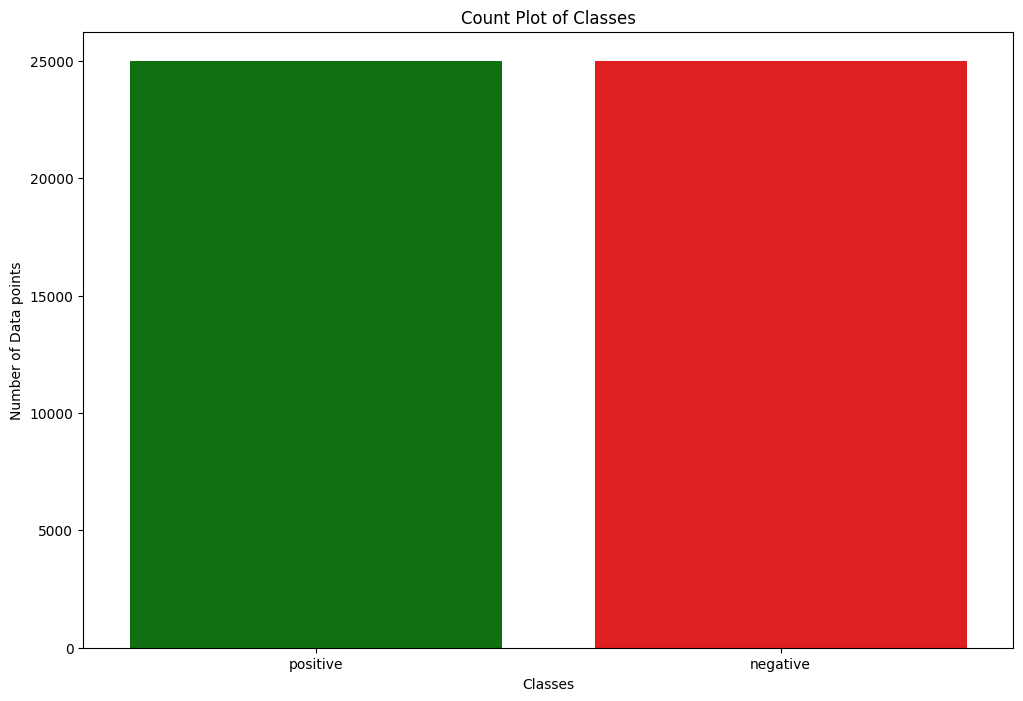

In [4]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["sentiment"], palette= ['green', 'red'])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points",)

they're fine

In [5]:
data["No_of_Characters"] = data["review"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["review"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["review"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,50000.0,1309.43102,989.728014,32.0,699.0,970.0,1590.25,13704.0
No_of_Words,50000.0,279.48348,207.949644,8.0,151.0,209.0,340.00,2911.0
No_of_sentence,50000.0,10.74144,7.900587,1.0,6.0,9.0,13.00,282.0


<Figure size 1200x800 with 0 Axes>

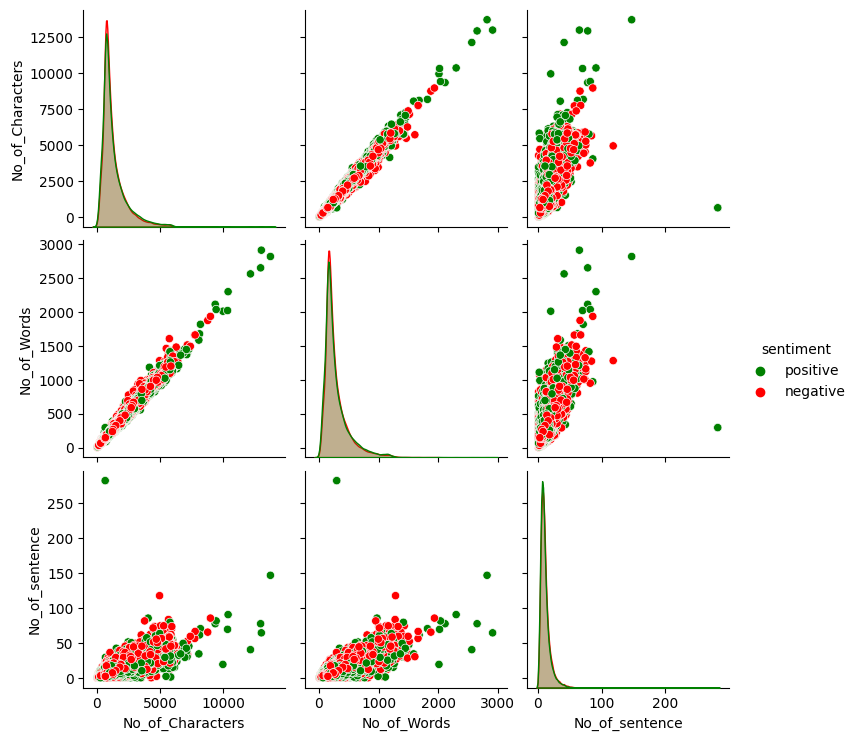

In [6]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="sentiment",palette=['green', 'red'])
plt.show(fg)

## Data preperocessing Steps

1. **HTML Tag Removal**:
   - Remove all HTML tags from the input data . This helps in cleaning up the text by eliminating unnecessary HTML markup.

2. **Case Normalization**:
   - Convert all words to lowercase to ensure uniformity and to prevent distinguishing between words based on their casing.

3. **Stopword Removal**:
   - Remove common stopwords (frequent words that do not contribute much meaning) from the text. 

4. **Web Links Removal**:
   - Remove any web links (URLs) from the input data using regular expressions or URL parsing techniques. This helps in reducing noise in the text.

5. **Symbol Removal**:
   - Remove symbols and special characters from the text, leaving only the alphanumeric content.

6. **Tokenization**:
   - Split the text into individual words or tokens. This is a crucial step in text processing.

7. **Stemming**:
   - Reduce words to their root form to standardize and simplify variations of words (e.g., "running" becomes "run").

In [7]:
pat1 = '<.*?>' #HTML Tag pattern
pat2 = r'http\S+' #Web Links pattern
pat3 = '[^a-zA-Z ]' #Symbol pattern
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()
stemmer = SnowballStemmer("english", True)


def PreProcessing(text):

    cleand_text = re.sub(pat1 , '' , text)

    cleand_text = re.sub(pat2 , '' , cleand_text)

    cleand_text = re.sub(pat3 , '' , cleand_text)

    cleand_text = cleand_text.lower()

    stop_word_removal = lambda text : [word for word in cleand_text if word  not in stop_words]

    tokenizer = lambda text : nltk.word_tokenize(text)

    stemmer_ = lambda text : [stemmer.stem(word) for word in text]

    cleand_text = tokenizer(cleand_text)

    cleand_text = stop_word_removal(cleand_text)

    return stemmer_(cleand_text)

In [8]:
data['cleaned'] = data['review'].apply(PreProcessing)
data.head()

,review,sentiment,No_of_Characters,No_of_Words,No_of_sentence,cleaned
0,One of the other reviewers has mentioned that ...,positive,1761,380,10,"[one, review, mention, watch, oz, episod, youl..."
1,A wonderful little production. <br /><br />The...,positive,998,201,7,"[wonder, littl, product, film, techniqu, unass..."
2,I thought this was a wonderful way to spend ti...,positive,926,205,4,"[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,748,175,6,"[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,283,9,"[petter, mattei, love, time, money, visual, st..."


let's vectirize our clean data

### 1. **Count Vectorization**
   - **How It Works:**
     Count Vectorization, also known as the Bag of Words model, converts text into a matrix where each cell represents the frequency count of a word in a document. It creates a vocabulary of all the unique words present across the dataset and counts the occurrences of each word in every document.

   - **Suitability:**
     - Count Vectorization is suitable for tasks where word frequency matters more than word context, such as basic document classification or spam detection. However, it may not be ideal for tasks requiring semantic understanding of the text.

### 2. **TF-IDF Vectorization**
   - **How It Works:**
     TF-IDF (Term Frequency-Inverse Document Frequency) is an improvement over Count Vectorization. It calculates the importance of a word in a document relative to its occurrence across all documents. The formula is typically given by:

           TF-IDF = TF*IDF

     - **Term Frequency (TF):** The number of times a word appears in a document, normalized by the total number of words in the document.
     - **Inverse Document Frequency (IDF):** A measure of how unique or rare a word is across the entire dataset. Words that appear frequently across many documents get a lower score.

   - **Suitability:**
     - TF-IDF is well-suited for tasks that require distinguishing between important and unimportant words, such as document ranking in search engines, keyword extraction, and more complex text classification tasks.

In [9]:
tfidf_vectorize = TfidfVectorizer()
hash_vectorize = HashingVectorizer(binary=True, n_features=70000) # for BernoulliNB model

sents = []

for sent in data['cleaned']:
    sents.append(' '.join([row for row in sent]))

hash_data = hash_vectorize.fit_transform(sents)
tf_data = tfidf_vectorize.fit_transform(sents)


## Building model

In [10]:
X_train, X_test, y_train,y_test = train_test_split(tf_data, data.sentiment,test_size= 0.2,random_state=101)

In [11]:
# Let's check the shape of the train and test dataset
print(f'The shape of the train and test set for the independent variables are : X_train = {X_train.shape}, X_test = {X_test.shape}')
print(f'The shape of the train and test set for the dependent variables are : y_train = {y_train.shape}, y_test = {y_test.shape}')

The shape of the train and test set for the independent variables are : X_train = (40000, 174302), X_test = (10000, 174302)
The shape of the train and test set for the dependent variables are : y_train = (40000,), y_test = (10000,)


In [12]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [13]:
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8584

In [14]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      4959
    positive       0.88      0.84      0.86      5041

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



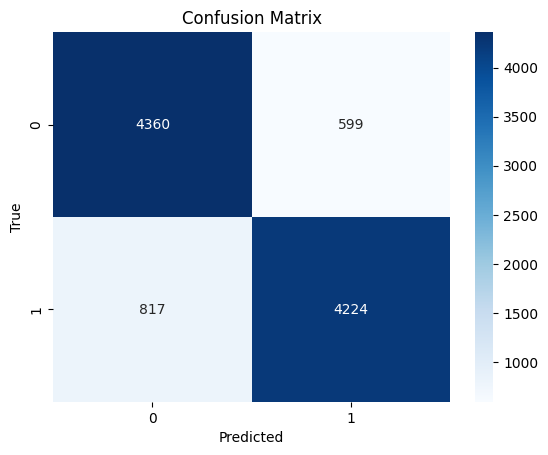

In [15]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

GussianNB

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

anova_selector = SelectKBest(f_classif, k=1500)
X_reduced1 = anova_selector.fit_transform(tf_data, data.sentiment)

In [17]:
X_train, X_test, y_train,y_test = train_test_split(X_reduced1, data.sentiment,test_size= 0.2,random_state=101)

In [18]:
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

GaussianNB()

In [19]:
pred = model.predict(X_test.toarray())
accuracy_score(y_test,pred)

0.8147

In [20]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81      4959
    positive       0.79      0.85      0.82      5041

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



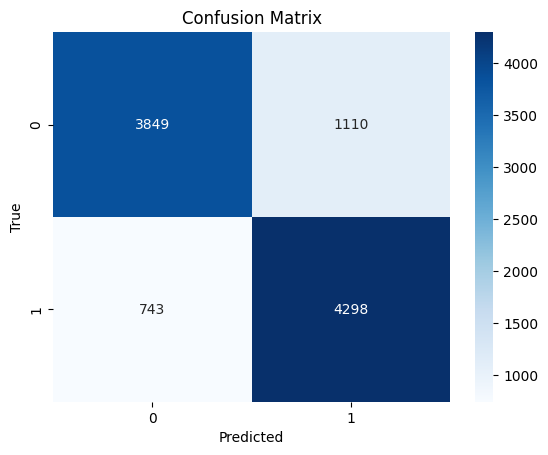

In [21]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

BernoulliNB

In [22]:
X_train, X_test, y_train,y_test = train_test_split(hash_data, data.sentiment,test_size= 0.2,random_state=101)

In [23]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [24]:
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8481

In [25]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85      4959
    positive       0.87      0.82      0.84      5041

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



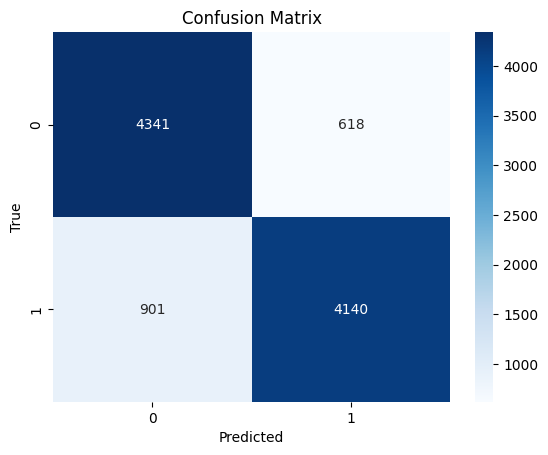

In [26]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()